# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader 
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [2]:
image_size=64
batch_size=128
stats= (0.5,),(0.5,),(0.5,)

In [3]:
transform = T.Compose([
    T.Resize([image_size,image_size]),
    T.CenterCrop((64,64)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                 ])

In [4]:
if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

CUDA is available


In [5]:
data_dir='img_align_celeba/'
dataset = datasets.ImageFolder(root=data_dir , transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


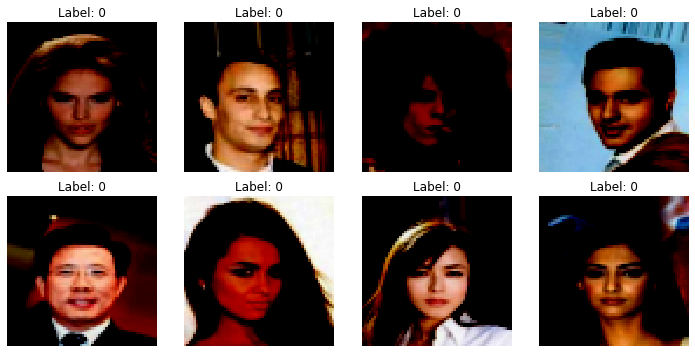

In [6]:
import matplotlib.pyplot as plt

# Visualize the images
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
axs = axs.flatten()

for i, (images, labels) in enumerate(data_loader):
    if i >= 8:
        break
    image = images[0].permute(1, 2, 0).numpy()  # Rearrange the color channels and convert to a NumPy array
    axs[i].imshow(image)
    axs[i].set_title(f"Label: {labels[0].item()}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [7]:
image, _ = dataset[0]
image_size = image.shape

print("Image size:", image_size)

Image size: torch.Size([3, 64, 64])


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
device

'cuda'

In [10]:
#seed = 42
#torch.manual_seed(seed)

# Define the discriminator and generator classes
class Discriminator(nn.Module):
    def __init__(self, image_dim):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(28),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
#              nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
#              nn.BatchNorm2d(128),
#              nn.LeakyReLU(0.2),

#              nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
#              nn.BatchNorm2d(512),
#              nn.LeakyReLU(0.2),
            
#             nn.Linear(4096, 1)
            nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.Flatten(),
            nn.Dropout(0.25),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            
            nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
 
                       
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(128),
             nn.ReLU(), 
            
            
            nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),   
          

            nn.ConvTranspose2d(256, 512, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            #nn.ConvTranspose2d(512, 1024, kernel_size=4, stride=2, padding=0, bias=False),
            #nn.BatchNorm2d(1024),
            #nn.ReLU(),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),       
            
            nn.ConvTranspose2d(512, 3, kernel_size=5, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        
        return self.gen(x)


In [13]:
lr = 0.0003
lr_disc = 0.0002
lr_gan = 0.00002
beta_1 = 0.5 
beta_2 = 0.999
latent_size = 100
image_dim = 64 * 64 * 3
#batch_size = 32
num_epochs = 10

In [14]:
discriminator= Discriminator(image_dim).to(device)
generator = Generator(latent_size).to(device)
#fixed_noise = torch.randn(latent_size).to(device)
fixed_noise = torch.randn(batch_size, latent_size,1,1).to(device)

#fake_images=Generator(fixed_noise)

In [15]:
opt_disc = optim.Adam(discriminator.parameters(), lr=lr,betas=(beta_1, beta_2))#
opt_gen = optim.Adam(generator.parameters(), lr=lr,betas=(beta_1, beta_2))#
criterion = nn.BCELoss()


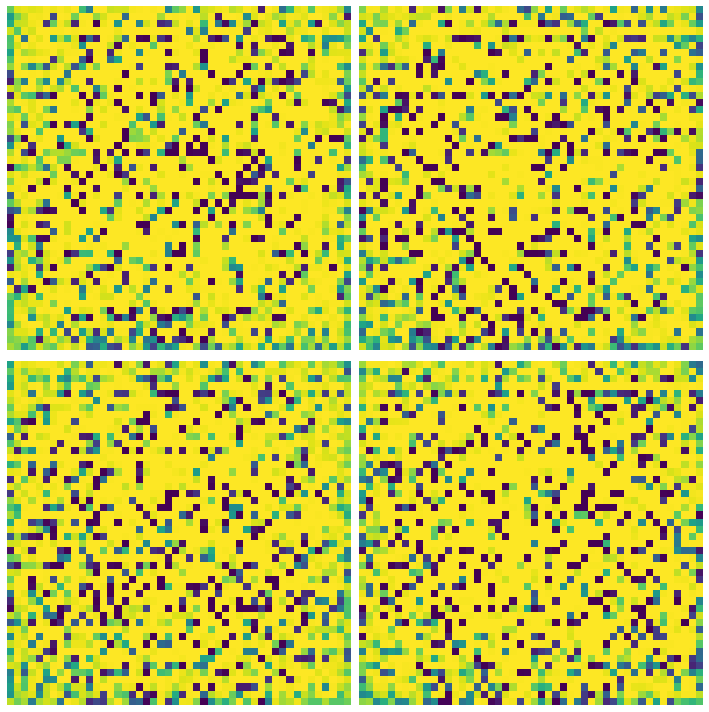

In [16]:
# Convert fixed noise to image
fake_images = generator(fixed_noise)

# Reshape the fake images to (batch_size, channels, height, width)
#fake_images = fake_images.reshape(batch_size, 1, 28, 28)

# Convert the tensor to a numpy array
fake_images = fake_images.cpu().detach().numpy()

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(fake_images[i][0])
    ax.axis('off')

plt.tight_layout()
plt.show()

Epoch [1/10] Batch 0/1583                 Loss D: 0.7165, Loss G: 0.8197


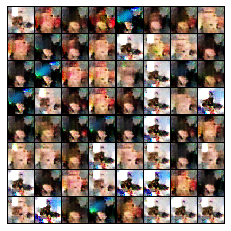

Epoch [2/10] Batch 0/1583                 Loss D: 0.5496, Loss G: 0.9533


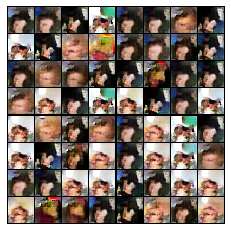

Epoch [3/10] Batch 0/1583                 Loss D: 0.4642, Loss G: 1.2334


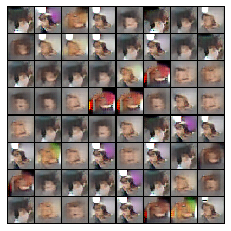

Epoch [4/10] Batch 0/1583                 Loss D: 0.4041, Loss G: 1.4294


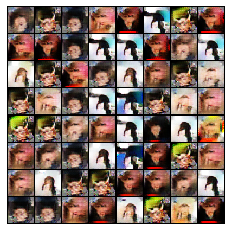

Epoch [5/10] Batch 0/1583                 Loss D: 0.3831, Loss G: 1.5350


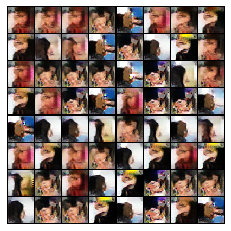

Epoch [6/10] Batch 0/1583                 Loss D: 0.3422, Loss G: 1.7667


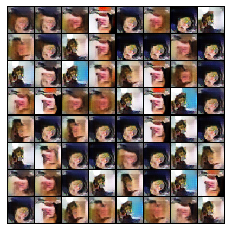

Epoch [7/10] Batch 0/1583                 Loss D: 0.3353, Loss G: 1.7535


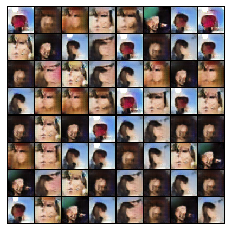

Epoch [8/10] Batch 0/1583                 Loss D: 0.3882, Loss G: 1.8084


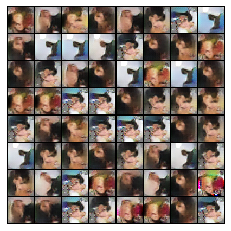

Epoch [9/10] Batch 0/1583                 Loss D: 0.3132, Loss G: 1.8467


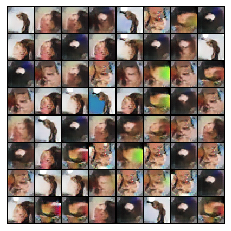

Epoch [10/10] Batch 0/1583                 Loss D: 0.2890, Loss G: 2.1131


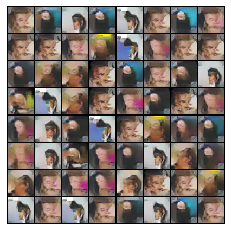

In [17]:
import torchvision.utils as vutils

# Training loop
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(data_loader):
        real = real.to(device)
        batch_size = real.shape[0]

        # Train the Discriminator
        noise = torch.randn(batch_size, latent_size,1,1).to(device)
        fake = generator(noise)
        disc_real = discriminator(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake.detach()).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        discriminator.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        # Train the Generator
        output = discriminator(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(data_loader)} \
                Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
            )

    # Generate samples after each epoch
    with torch.no_grad():
        fixed_noise = torch.randn(64, latent_size, 1, 1).to(device)
        fake = generator(fixed_noise)
        fake_images = fake.cpu()
        img_grid_fake = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
        plt.imshow(np.transpose(img_grid_fake, (1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()



In [18]:
import torch
import numpy as np
from torchvision.transforms import functional as F
from torchvision.utils import save_image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of images to generate
num_images = 100

# Random latent samples
z = torch.randn(num_images, latent_size, 1, 1).to(device)

# Generate fake images
fake_images = generator(z)

# Resize the fake images to the desired size [100, 1, 28, 28]
fake_images_resized = F.resize(fake_images, (64, 64))

# Save generated images
save_image(fake_images_resized, 'fake_images.png', nrow=10, normalize=True)


In [19]:
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_images=50
# Random latent samples
z = torch.randn(num_images, latent_size,1,1).to(device)

# Generate fake images
fake_images = generator(z)
fake_images_resized = F.resize(fake_images, (128, 128))
# Create a folder for saving fake digits
save_folder = "Fake Digits1"
os.makedirs(save_folder, exist_ok=True)

# Save generated images and latent samples
for i in range(num_images):
    # Save fake image
    fake_image_path = os.path.join(save_folder, f"fake_image_{i+1}.png")
    vutils.save_image(fake_images[i], fake_image_path, normalize=True)

    # Save latent sample
    latent_sample_path = os.path.join(save_folder, f"latent_sample_{i+1}.pt")
    torch.save(z[i], latent_sample_path)

print("Fake images and latent samples saved successfully.")


Fake images and latent samples saved successfully.


In [ ]:
with open(model_path, 'rb') as f:
    model_state = pickle.load(f)


In [ ]:
import torch
import pickle

latent_size = 100

# Load generator model
generator_path = 'dcgan_model_untitled9.pkl'
with open(generator_path, 'rb') as f:
    generator_state = pickle.load(f)
    generator = Generator(latent_size=latent_size)
    generator.load_state_dict(generator_state['generator'])
    generator.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of images to generate
num_images = 100

# Random latent samples
latent_dim = latent_size
z = torch.randn(num_images, latent_dim).to(device)

# Generate fake images
fake_images = generator(z)

# Save generated images
torchvision.utils.save_image(fake_images, 'fake_images2.png', nrow=10, normalize=True)


In [ ]:
import os
import torch
import torchvision.utils as vutils
import pickle

latent_size = 100
num_images = 100

# Load the saved generator model
generator_path = 'dcgan_model_untitled9.pkl'
with open(generator_path, 'rb') as f:
    generator_state = pickle.load(f)
    generator = Generator(latent_size=latent_size)
    generator.load_state_dict(generator_state['generator'])
    generator.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Random latent samples
z = torch.randn(num_images, latent_size,1,1).to(device)

# Generate fake images
fake_images = generator(z)

# Create a folder for saving fake digits
save_folder = "Fake Digits1"
os.makedirs(save_folder, exist_ok=True)

# Save generated images and latent samples
for i in range(num_images):
    # Save fake image
    fake_image_path = os.path.join(save_folder, f"fake_image_{i+1}.png")
    vutils.save_image(fake_images[i], fake_image_path, normalize=True)

    # Save latent sample
    latent_sample_path = os.path.join(save_folder, f"latent_sample_{i+1}.pt")
    torch.save(z[i], latent_sample_path)

print("Fake images and latent samples saved successfully.")


In [ ]:
import os
import torch
import torchvision.utils as vutils
import pickle

latent_size = 100
num_images = 100
image_size = 64  # Desired image size

# Load the saved generator model
generator_path = 'dcgan_model_untitled9.pkl'
with open(generator_path, 'rb') as f:
    generator_state = pickle.load(f)
    generator = Generator(latent_size=latent_size)
    generator.load_state_dict(generator_state['generator'])
    generator = generator.to(device)  # Move the model to the same device as input
    generator.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Random latent samples
z = torch.randn(num_images, latent_size, 1, 1).to(device)
z = torch.nn.functional.interpolate(z, size=(image_size, image_size))  # Increase the size of z

# Generate fake images
fake_images = generator(z)

# Create a folder for saving fake digits
save_folder = "Fake Digits"
os.makedirs(save_folder, exist_ok=True)

# Save generated images and latent samples
for i in range(num_images):
    # Save fake image
    fake_image_path = os.path.join(save_folder, f"fake_image_{i+1}.png")
    vutils.save_image(fake_images[i].detach().cpu(), fake_image_path, normalize=True)

    # Save latent sample
    latent_sample_path = os.path.join(save_folder, f"latent_sample_{i+1}.pt")
    torch.save(z[i].detach().cpu(), latent_sample_path)

print("Fake images and latent samples saved successfully.")


In [ ]:
import os
import torch
import torchvision.utils as vutils
import pickle
import numpy as np

latent_size = 100
num_images = 100

# Load the saved generator model
generator_path = 'dcgan_model_untitled9.pkl'
with open(generator_path, 'rb') as f:
    generator_state = pickle.load(f)
    generator = Generator(latent_size=latent_size)
    generator.load_state_dict(generator_state['generator'])
    generator = generator.to(device)  # Move the model to the same device as input
    generator.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Random latent samples
z = torch.randn(num_images, latent_size, 1, 1).to(device)

# Generate fake images
fake_images = generator(z)

# Create a folder for saving fake digits
save_folder = "Fake Digits3"
os.makedirs(save_folder, exist_ok=True)

# Save generated images and latent samples
for i in range(num_images):
    # Save fake image
    fake_image_path = os.path.join(save_folder, f"fake_image_{i+1}.png")
    vutils.save_image(fake_images[i].detach().cpu(), fake_image_path, normalize=True)

    # Reshape and save latent sample as .txt file
    latent_sample = z[i].detach().cpu().numpy().reshape(-1)
    latent_sample_path = os.path.join(save_folder, f"latent_sample_{i+1}.txt")
    np.savetxt(latent_sample_path, latent_sample)

print("Fake images and latent samples saved successfully.")


In [ ]:
import os
import torch
import torchvision.utils as vutils
import pickle
import numpy as np

latent_size = 100
num_images_per_digit = 100
num_digits = 10
total_images = num_images_per_digit * num_digits

# Load the saved generator model
generator_path = 'dcgan_model_untitled9.pkl'
with open(generator_path, 'rb') as f:
    generator_state = pickle.load(f)
    generator = Generator(latent_size=latent_size)
    generator.load_state_dict(generator_state['generator'])
    generator = generator.to(device)  # Move the model to the same device as input
    generator.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a folder for saving fake digits
save_folder = "Fake Digits Num by Num"
os.makedirs(save_folder, exist_ok=True)

# Generate and save images for each digit
for digit in range(num_digits):
    # Random latent samples
    z = torch.randn(num_images_per_digit, latent_size, 1, 1).to(device)

    # Generate fake images
    fake_images = generator(z)

    for i in range(num_images_per_digit):
        # Save fake image
        fake_image_path = os.path.join(save_folder, f"fake_digit_{digit}_{i+1}.png")
        vutils.save_image(fake_images[i].detach().cpu(), fake_image_path, normalize=True)

        # Reshape and save latent sample as .txt file
        latent_sample = z[i].detach().cpu().numpy().reshape(-1)
        latent_sample_path = os.path.join(save_folder, f"latent_sample_{digit}_{i+1}.txt")
        np.savetxt(latent_sample_path, latent_sample)

print("Fake images and latent samples saved successfully.")


In [ ]:
import os
import torch
import torchvision.utils as vutils
import pickle
import numpy as np

latent_size = 100
num_images_per_digit = 100
num_digits = 10
total_images = num_images_per_digit * num_digits

# Load the saved generator model
generator_path = 'dcgan_model_untitled9.pkl'
with open(generator_path, 'rb') as f:
    generator_state = pickle.load(f)
    generator = Generator(latent_size=latent_size)
    generator.load_state_dict(generator_state['generator'])
    generator = generator.to(device)  # Move the model to the same device as input
    generator.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a folder for saving fake digits
save_folder = "Fake Digits2"
os.makedirs(save_folder, exist_ok=True)

# Generate and save images for each digit
for digit in range(num_digits):
    digit_folder = os.path.join(save_folder, str(digit))
    os.makedirs(digit_folder, exist_ok=True)

    # Random latent samples
    z = torch.randn(num_images_per_digit, latent_size, 1, 1).to(device)

    # Generate fake images
    fake_images = generator(z)

    for i in range(num_images_per_digit):
        # Save fake image
        fake_image_path = os.path.join(digit_folder, f"fake_image_{i+1}.png")
        vutils.save_image(fake_images[i].detach().cpu(), fake_image_path, normalize=True)

        # Reshape and save latent sample as .txt file
        latent_sample = z[i].detach().cpu().numpy().reshape(-1)
        latent_sample_path = os.path.join(digit_folder, f"latent_sample_{i+1}.txt")
        np.savetxt(latent_sample_path, latent_sample)

print("Fake images and latent samples saved successfully.")


In [ ]:
import os
import torch
import torchvision.utils as vutils
import pickle
import numpy as np

latent_size = 100
num_images_per_digit = 100
num_digits = 10
total_images = num_images_per_digit * num_digits

# Load the saved generator model
generator_path = 'dcgan_model_untitled9.pkl'
with open(generator_path, 'rb') as f:
    generator_state = pickle.load(f)
    generator = Generator(latent_size=latent_size)
    generator.load_state_dict(generator_state['generator'])
    generator = generator.to(device)  # Move the model to the same device as input
    generator.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a folder for saving fake digits
save_folder = "Fake Digits num by num 2"
os.makedirs(save_folder, exist_ok=True)

# Generate and save fake images and latent samples for each digit
for digit in range(num_digits):
    # Random latent samples for the current digit
    z = torch.randn(num_images_per_digit, latent_size, 1, 1).to(device)

    # Generate fake images
    fake_images = generator(z)

    # Create a folder for the current digit
    digit_folder = os.path.join(save_folder, str(digit))
    os.makedirs(digit_folder, exist_ok=True)

    # Save generated images and latent samples for the current digit
    for i in range(num_images_per_digit):
        # Save fake image
        fake_image_path = os.path.join(digit_folder, f"fake_image_{i+1}.png")
        vutils.save_image(fake_images[i].detach().cpu(), fake_image_path, normalize=True)

        # Save latent sample as .txt file
        latent_sample_path = os.path.join(digit_folder, f"latent_sample_{i+1}.txt")
        np.savetxt(latent_sample_path, z[i].detach().cpu().numpy().reshape(-1))

print("Fake images and latent samples saved successfully.")


In [ ]:
import os
import torchvision.utils as vutils

# Create a folder to save the images
save_folder = "S0"
os.makedirs(save_folder, exist_ok=True)

# Save the images
for i, (image, label) in enumerate(S0):
    # Save the image
    image_path = os.path.join(save_folder, f"image_{i+1}.png")
    vutils.save_image(image, image_path, normalize=True)

print("Images saved successfully.")


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=36,  #16
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(36, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization



In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import pickle

# Load the saved CNN model
model_path = 'C.pkl'
with open(model_path, 'rb') as f:
    model = pickle.load(f)

# Load the S0 dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
s0_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loader for the S0 dataset
batch_size = 100
s0_dataloader = torch.utils.data.DataLoader(s0_dataset, batch_size=batch_size, shuffle=True)

# Set the model in evaluation mode
model.eval()

# Track the number of misclassified samples
num_misclassified = 0

# Iterate over the S0 dataset and compute the classification error
with torch.no_grad():
    for images, labels in s0_dataloader:
        # Forward pass
        outputs, _ = model(images)

        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Count the number of misclassified samples
        num_misclassified += (predicted != labels).sum().item()

# Calculate the classification error
classification_error = num_misclassified / len(s0_dataset)

print(f"S0 Classification Error: {classification_error * 100}%")


In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import pickle

# Load the saved CNN model
model_path = 'C.pkl'
with open(model_path, 'rb') as f:
    model = pickle.load(f)

# Load the S0 dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
s0_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loader for the S0 dataset
batch_size = 100
s0_dataloader = torch.utils.data.DataLoader(s0_dataset, batch_size=batch_size, shuffle=True)

# Set the model in evaluation mode
model.eval()

# Track the number of misclassified samples
num_misclassified = 0

# Iterate over the S0 dataset and compute the classification error
with torch.no_grad():
    for images, labels in s0_dataloader:
        # Forward pass
        outputs, _ = model(images)

        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Count the number of misclassified samples
        num_misclassified += (predicted != labels).sum().item()

# Calculate the classification error
classification_error = num_misclassified / len(s0_dataset)

print(f"S0 Classification Error: {classification_error * 100}%")


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pickle
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = [file for file in os.listdir(self.root_dir) if file.endswith('.png')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.file_list[index])
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image

# Load the saved classifier model
model_path = 'C.pkl'
with open(model_path, 'rb') as f:
    model = pickle.load(f)

# Load the S1 dataset
dataset_path = 'S1'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = CustomDataset(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Evaluate the classification error
correct = 0
total = 0
with torch.no_grad():
    for images in dataloader:
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += images.size(0)
        correct += predicted.eq(1).sum().item()

classification_error = 100 * (1 - correct / total)
print(f"Classification Error: {classification_error:.2f}%")
